In [17]:
import cv2
import matplotlib.patches as patches
import numpy as np
import plotly.express as px
from matplotlib import pyplot as plt

from anpr.binarization.adaptative_gaussian import AdaptativeGaussianBinarizer
from anpr.binarization.adaptative_mean import AdaptativeMeanBinarizer
from anpr.binarization.kittler import KittlerBinarizer
from anpr.binarization.otsu import OtsuBinarizer
from anpr.core.binarizer import Binarizer
from anpr.core.image_processor import ImageProcessor
from anpr.datasets.open_alpr import OpenALPRDataset, OpenALPRImage
from anpr.detection.estimator_detector import EstimatorDetector
from anpr.generic.brightness import Brightness
from anpr.generic.contrast import Contrast
from anpr.generic.filter_bilateral import FilterBilateral
from anpr.generic.filter_gaussian import FilterGaussian
from anpr.generic.filter_mean import FilterMean
from anpr.generic.filter_median import FilterMedian
from anpr.generic.filter_nlm import FilterNLM
from anpr.generic.grayscale import GrayScale
from anpr.generic.histogram_normalization import HistogramNormalization
from anpr.generic.morphological_closing import MorphologicalClosing
from anpr.generic.morphological_opening import MorphologicalOpening
from anpr.generic.negative import Negative
from anpr.ocr.easy_ocr import EasyOCR

In [18]:
class AggregateProcessor(ImageProcessor):
    def __init__(self, processors: list[ImageProcessor]) -> None:
        self._processors = processors

    def process(self, image: np.ndarray) -> np.ndarray:
        for p in self._processors:
            image = p.process(image)

        return image

In [19]:
ds = OpenALPRDataset()
indices = [0, 30, 50, 80, 100, 120, 180, 200, 220, 240, 300, 320, 380, 400, 420]

In [20]:
start = [FilterNLM(21),
         FilterBilateral(11, 5, 5),
         GrayScale(),
         Brightness(-30),
         HistogramNormalization(),
         Contrast(0.5)]

segmentation = [OtsuBinarizer(),
                AdaptativeMeanBinarizer(11, 5),
                Negative()]

processor = AggregateProcessor(start + segmentation)

In [21]:
detector = EstimatorDetector(seed=42,
                             preprocessing=processor,
                             pp_in_predict=True)
detector.fit(indices, ds)

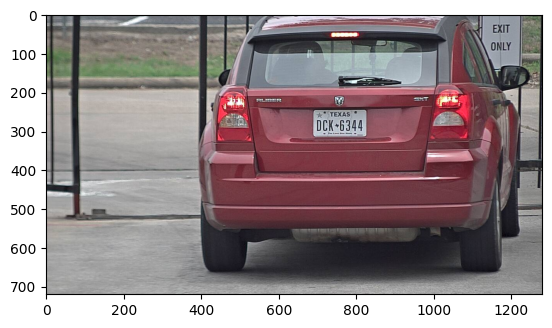

In [26]:
img = ds.image_at(420).image
plt.imshow(img)

In [27]:
result = detector.detect(img)

Encontrados 264 retângulos...
Restaram 257 retângulos após remoção de retângulos grandes...
Restaram 137 retângulos após remoção de retângulos pequenos...
Restaram 43 retângulos após remoção de retângulos com proporção inviável...
Restaram 31 após remoção de overlap...
Restaram 21 retângulos após remoção dos sem vizinhos próximos...
Quantidade de candidatos finais: 1


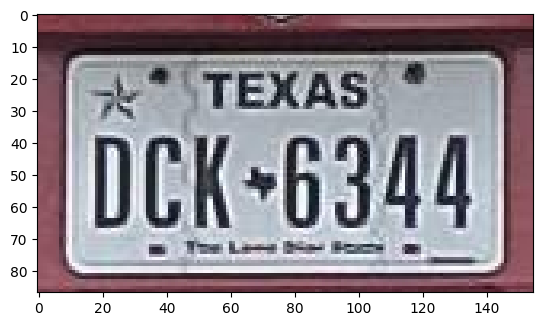

In [28]:
plt.imshow(result.plate_image)

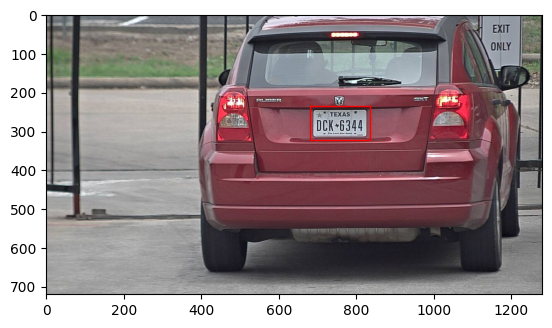

In [29]:
fig, ax = plt.subplots()
ax.imshow(img)

for c in result.extras.candidates:
    x, y, w, h = c
    ax.add_patch(patches.Rectangle((x, y), w, h, 
                                linewidth=1, 
                                edgecolor='r', 
                                facecolor='none'))
